## Part 1: Data Loading

In [114]:
# Madelyne Wirbel -- HW1 -- CAP4770
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn.cluster import KMeans

df = pd.DataFrame() # creation of the data frame
frame_list = [] # creation of the list of frames
directory = 'data'


for filename in os.listdir(directory): # iterates through the file names and adds them to the frame_list
    f = os.path.join(directory, filename)

    if os.path.isfile(f) & f.endswith('.txt'):
        frame_list.append(f)


for frame in frame_list: # reads the files in the frame_list to the data frames
    df_temp = pd.read_csv(frame, sep='\t',
    names=['cur_time', 'vehicle_id', 'x_cord', 'y_cord', 'vehicle_or_pedestrian',
    'cluster', 'signal', 'entry', 'maneuver'],
    header=None, index_col=False)
    
    df = pd.concat([df, df_temp], ignore_index = True) # concatinates all the data frames together

df

# df.describe() --> gives df info (statistics)
# df.info() --> gives col value info types

,cur_time,vehicle_id,x_cord,y_cord,vehicle_or_pedestrian,cluster,signal,entry,maneuver
0,100000,3422,129.756554,303.823351,0.0,1,3.0,2,1
1,100000,3425,170.189293,333.165159,0.0,0,3.0,2,2
2,100000,3428,159.101178,296.279506,0.0,10,0.0,0,0
3,100000,3429,130.336135,300.119699,0.0,2,3.0,2,1
4,100000,3431,168.465652,284.702094,0.0,3,3.0,2,0
...,...,...,...,...,...,...,...,...,...
2193802,99999,3431,168.548827,285.364328,0.0,3,3.0,2,0
2193803,99999,3434,168.201682,257.004640,0.0,7,3.0,0,2
2193804,99999,3435,152.866223,296.170345,0.0,10,0.0,0,0
2193805,99999,3439,171.787028,308.025455,0.0,0,3.0,2,2


In [115]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2193807 entries, 0 to 2193806
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   cur_time               int64  
 1   vehicle_id             int64  
 2   x_cord                 float64
 3   y_cord                 float64
 4   vehicle_or_pedestrian  float64
 5   cluster                int64  
 6   signal                 float64
 7   entry                  int64  
 8   maneuver               int64  
dtypes: float64(4), int64(5)
memory usage: 150.6 MB


### Pandas and Seaborn Demos

<Axes: xlabel='cur_time', ylabel='x_cord'>

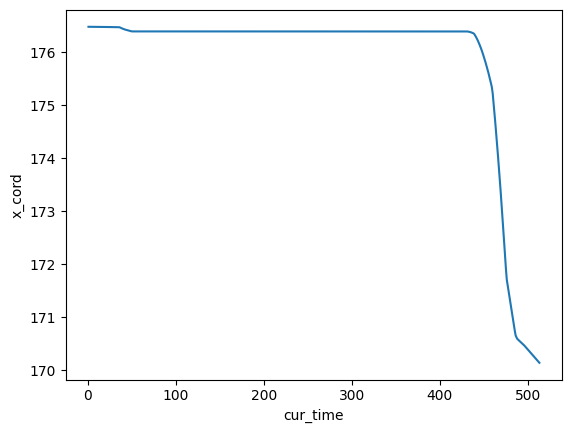

In [116]:
df_0 = df[df['vehicle_id'] == 0 ]
sns.lineplot(x = 'cur_time', y = 'x_cord', data = df_0)

<Axes: xlabel='cur_time', ylabel='y_cord'>

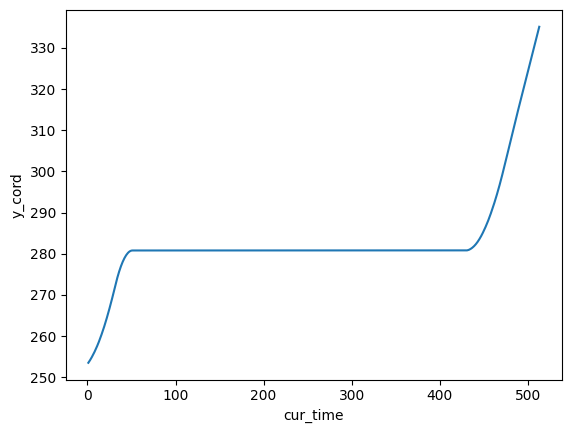

In [117]:
df_0 = df[df['vehicle_id'] == 0]
sns.lineplot(x='cur_time', y='y_cord', data=df_0)

<Axes: xlabel='x_cord', ylabel='y_cord'>

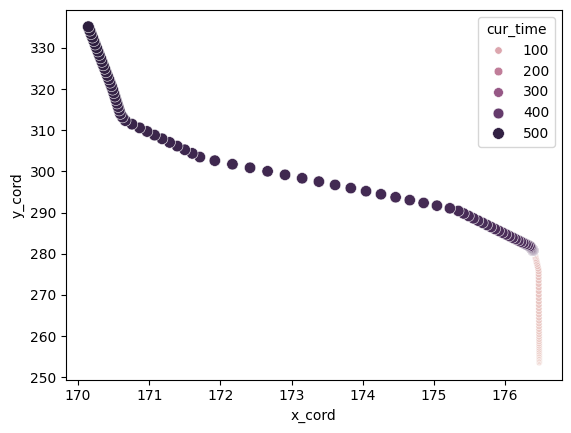

In [118]:
df_0 = df[df['vehicle_id'] == 0]
sns.scatterplot(x='x_cord', y='y_cord', data=df_0, hue='cur_time', size='cur_time')

## Part 2: Spatial Clustering

### Step 1: Initial Clustering

In [120]:
e_and_m_df = df[['entry', 'maneuver']] # create a data frame with entries and maneuvers

# find the kmeans of the new data frame
kmeans_entry_maneuver = KMeans(n_clusters = 11, random_state = 0)
df['kmeans_entry_maneuver'] = kmeans_entry_maneuver.fit_predict(e_and_m_df)

# doesn't recognize the difference in the two types of straight lanes

c:\Users\kenda\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1473: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (11). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


<Figure size 1000x600 with 0 Axes>

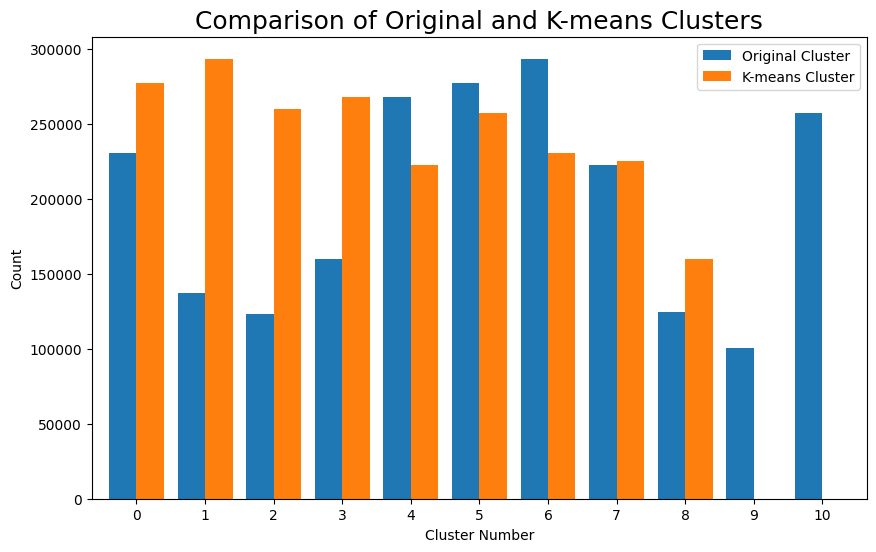

In [121]:
# create comparison cluster counts from the original and kmeans data frames
original_cluster_counts = df['cluster'].value_counts().sort_index()
kmeans_cluster_counts = df['kmeans_entry_maneuver'].value_counts().sort_index()

# create a data frame with both the original and kmeans data frames 
comparison_df = pd.DataFrame({
    'Original Cluster': original_cluster_counts, 'K-means Cluster': kmeans_cluster_counts}).reset_index().rename(columns={'index': 'Cluster'})

plt.figure(figsize=(10, 6)) # creating the plot
comparison_df.plot(x='Cluster', kind='bar', width=0.8, figsize=(10,6))

# plot details
plt.title('Comparison of Original and K-means Clusters', fontsize=18)
plt.ylabel('Count')
plt.xlabel('Cluster Number')
plt.xticks(rotation=0) # justify values on x-axis
plt.legend(['Original Cluster', 'K-means Cluster'])
plt.show() # prints the plot

In [122]:
# accuracy test for the entry and maneuver clustering
df['kmeans_check'] = df['cluster'] == df['kmeans_entry_maneuver']

kmeans_eandm_check = df.groupby(['kmeans_check']).count()
kmeans_eandm_check['kmeans_entry_maneuver']

kmeans_check
False    2070937
True      122870
Name: kmeans_entry_maneuver, dtype: int64

### Step 2: Clustering using Trajectories

In [123]:
# creation of a max_x column in the data frame
max_x = df.groupby('vehicle_id')['x_cord'].max().reset_index()
max_x.columns = ['vehicle_id', 'max_x']

df = df.merge(max_x, on = 'vehicle_id') 

# creation of a min_x column in the data frame
min_x = df.groupby('vehicle_id')['x_cord'].min().reset_index()
min_x.columns = ['vehicle_id', 'min_x']

df = df.merge(min_x, on = 'vehicle_id')

# creation of a max_y column in the data frame
max_y = df.groupby('vehicle_id')['y_cord'].max().reset_index()
max_y.columns = ['vehicle_id', 'max_y']

df = df.merge(max_y, on = 'vehicle_id') 

# creation of a min_y column in the data frame
min_y = df.groupby('vehicle_id')['y_cord'].min().reset_index()
min_y.columns = ['vehicle_id', 'min_y']

df = df.merge(min_y, on = 'vehicle_id')

In [124]:
df['change_x'] = df['max_x'] - df['min_x'] # create a data frame for the change of x_cord for each vehicle
df['change_y'] = df['max_y'] - df['min_y'] # create a data frame for the change of y_cord for each vehicle

change_df = df[['change_x', 'change_y']] # create a data frame made up of the chnages of both coordinate systems


# find the kmeans of the new data frame
kmeans = KMeans(n_clusters = 11, random_state = 0) 
df['kmeans_traj'] = kmeans.fit_predict(change_df)

<Figure size 1000x600 with 0 Axes>

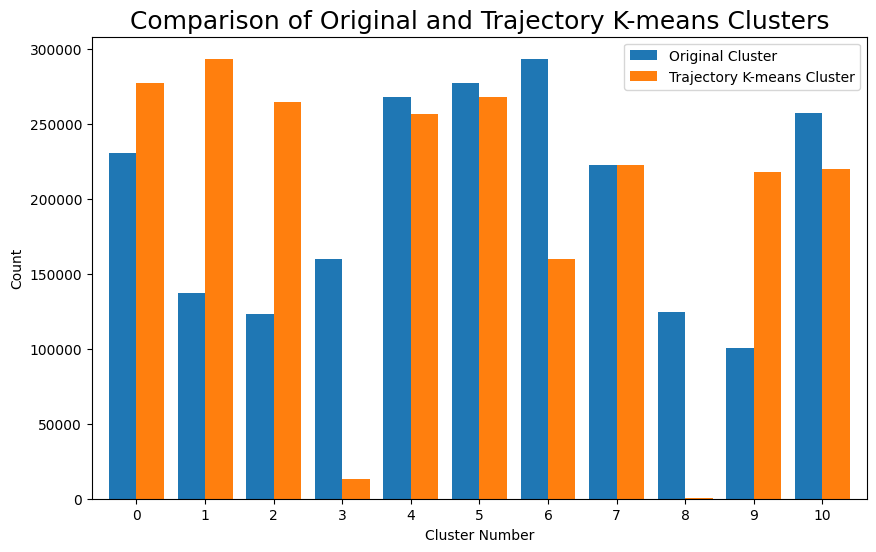

In [125]:
# same plotting code as used for step 1

# create comparison cluster counts from the original and change in trajectory kmeans data frames
original_cluster_counts = df['cluster'].value_counts().sort_index()
kmeans_cluster_counts = df['kmeans_traj'].value_counts().sort_index()

# create a data frame with both the original and change in trajectory kmeans data frames 
comparison_df_2 = pd.DataFrame({
    'Original Cluster': original_cluster_counts, 'K-means Cluster': kmeans_cluster_counts}).reset_index().rename(columns={'index': 'Cluster'})

plt.figure(figsize=(10, 6)) # creating the plot
comparison_df_2.plot(x='Cluster', kind='bar', width=0.8, figsize=(10,6))

# plot details
plt.title('Comparison of Original and Trajectory K-means Clusters', fontsize=18)
plt.ylabel('Count')
plt.xlabel('Cluster Number')
plt.xticks(rotation=0) # justify values on x-axis
plt.legend(['Original Cluster', 'Trajectory K-means Cluster'])
plt.show() # prints the plot

In [126]:
# accuracy test for the trajectory clustering
df['kmeans_check'] = df['cluster'] == df['kmeans_traj']

kmeans_traj_check = df.groupby(['kmeans_check']).count()
kmeans_traj_check['kmeans_traj']

kmeans_check
False    1912065
True      281742
Name: kmeans_traj, dtype: int64

## Part 3: Temporal Clustering

### Step 1: Feature Creation

In [141]:
# creating a driving duration using the cur_time and minimum time for each vehicle
min_times = df.groupby('vehicle_id')['cur_time'].min().reset_index() # minimum current time is the minimum time of the vehicle
min_times.columns = ['vehicle_id', 'min_time']

df = df.merge(min_times, on = 'vehicle_id') # merging minimum times based on vehicle id

df['duration'] = df['cur_time'] - df['min_time'] # duration driving on highway is max - min times of a given vehicle

df.drop(columns = 'min_time', inplace = True)

duration_arr = np.array(df['duration']) # transform the duration column into an array
df['norm_arr'] = sklearn.preprocessing.normalize([duration_arr])[0] # normalize the array
df['norm_arr']

0          0.001741
1          0.001538
2          0.001131
3          0.000985
4          0.000811
             ...   
2193802    0.000808
2193803    0.000692
2193804    0.000663
2193805    0.000169
2193806    0.000023
Name: norm_arr, Length: 2193807, dtype: float64

In [142]:
# use the kmeans to find the clusters of the data frame
dur_df = df[['entry', 'maneuver', 'duration']] # create a data frame with drive time duration for each vehicle

# find the kmeans of the new data frame
kmeans_dur = KMeans(n_clusters = 11, random_state = 0)
df['kmeans_dur'] = kmeans_dur.fit_predict(dur_df)


df['kmeans_check_dur'] = df['cluster'] == df['kmeans_dur'] # compare the kmeans value to the assigned cluster value

kmeans_dur_check = df.groupby(['kmeans_dur']).count() # counts the accurate assignments
kmeans_dur_check['kmeans_check_dur'] # print the results 

kmeans_dur
0     250092
1     143767
2     337621
3      83866
4     198086
5     329883
6     115831
7     224240
8      41526
9     173129
10    295766
Name: kmeans_check_dur, dtype: int64

<Figure size 1000x600 with 0 Axes>

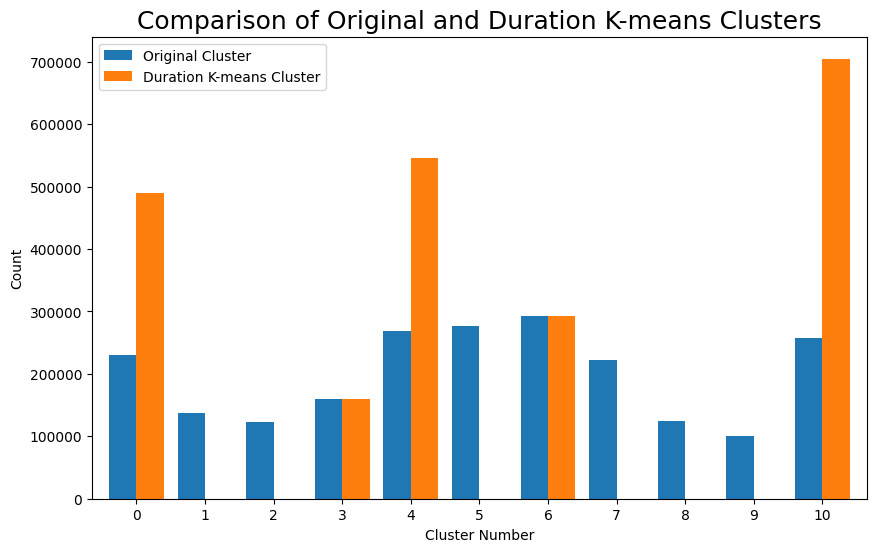

In [149]:
# same plotting code as used for step 1

# create comparison cluster counts from the original and duration kmeans data frames
original_cluster_counts = df['cluster'].value_counts().sort_index()
kmeans_cluster_counts = df['kmeans_dur'].value_counts().sort_index()

# create a data frame with both the original and duration kmeans data frames 
comparison_df_3 = pd.DataFrame({
    'Original Cluster': original_cluster_counts, 'K-means Cluster': kmeans_cluster_counts}).reset_index().rename(columns={'index': 'Cluster'})

plt.figure(figsize=(10, 6)) # creating the plot
comparison_df_3.plot(x='Cluster', kind='bar', width=0.8, figsize=(10,6))

# plot details
plt.title('Comparison of Original and Duration K-means Clusters', fontsize=18)
plt.ylabel('Count')
plt.xlabel('Cluster Number')
plt.xticks(rotation=0) # justify values on x-axis
plt.legend(['Original Cluster', 'Duration K-means Cluster'])
plt.show() # prints the plot

In [150]:
# accuracy test for duration clustering
df['kmeans_check'] = df['cluster'] == df['kmeans_dur']

kmeans_dur_check = df.groupby(['kmeans_check']).count()
kmeans_dur_check['kmeans_dur']

kmeans_check
False     984761
True     1209046
Name: kmeans_dur, dtype: int64

### Bonus: Adjusting the Duration K-means Clustering w/ Boundaries

In [152]:
# using the cluster to see different entries and maneuvers

df_cluster = df.groupby(df['cluster']).mean() # creates a data frame where information is grouped based on the clusters
print(df_cluster[['entry', 'maneuver']]) # prinitng the desired columns to observe the pattern in entries and maneuvers

         entry  maneuver
cluster                 
0          2.0       2.0
1          2.0       1.0
2          2.0       1.0
3          2.0       0.0
4          1.0       2.0
5          1.0       1.0
6          1.0       0.0
7          0.0       2.0
8          0.0       1.0
9          0.0       1.0
10         0.0       0.0


In [153]:
# manual assignment of the boundaries for clustering -- notes found in conclusion section of documentation
for index, row in df.iterrows():
    if row['entry'] == 2: # east bound entry
        if row['maneuver'] == 0: # left turn
            df.at[index, 'kmeans_dur'] = 3

        # cannot determine the straight maneuver for east bound entry

        elif [row['maneuver'] == 2]: # right turn
            df.at[index, 'kmeans_dur'] = 0

    elif row['entry'] == 1: # south bound entry
        if row['maneuver'] == 0: # left turn
            df.at[index, 'kmeans_dur'] = 6
        elif [row['maneuver'] == 2]: # right turn
            df.at[index, 'kmeans_dur'] = 4
        elif [row['maneuver'] == 1]: # straight
            df.at[index, 'kmeans_dur'] = 5

    elif row['entry'] == 0: # west bound entry
        if [row['maneuver'] == 0]: # left turn
            df.at[index, 'kmeans_dur'] = 10 

        # cannot determine the straight maneuver for west bound entry

        elif [row['maneuver'] == 2]: # right turn
            df.at[index, 'kmeans_dur'] = 7

df['adjusted_dur'] = df['cluster'] == df['kmeans_dur'] # compare the ADJUSTED kmeans value to the assigned cluster value
adjusted_df = df.groupby('adjusted_dur').count() # counts the accurate assignments
adjusted_df['kmeans_dur']

# shows highest accuracy in assigning the clusters when compared to the original cluster values

KeyboardInterrupt: 